# Building Deep Learning Systems (with Python)
Joaquin Vanschoren, Eindhoven University of Technology

In [1]:
# Global imports and settings
from preamble import *
import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using TensorFlow backend.


Using Keras 2.1.5


## Overview
* Multiclass classification (general)
* Binary text classification
* Multiclass text classification
* Regression (of house prices)
* Multiclass image classification

Examples from _Deep Learning with Python_

### Components of Neural Nets (recap)
* _Layers_ of nodes: transform an input tensor to an output tensor
    - Each with (a tensor of) weights to be fitted to the training data
    - Many types: dense, convolutional, recurrent,...
* _Loss function_: Measures whether the model fits the training data
* _Optimizer_: How to update the network, e.g. SGD

<img src="../images/09_overview.png" alt="ml" style="width: 400px;"/>

### A first example: classifying digits
- This example is meant to introduce the main concepts. We'll cover them in more detail later.
- MNIST dataset contains 28x28 pixel images of handwritten digits (0-9)
- The goal is to classify each image as one of the possible digits
- We __reshape__ the data to a 70000x28x28 __tensor__ (n-dimensional matrix)  
    `X = X.reshape(70000, 28, 28)`
- Traditional holdout uses the last 10,000 images for testing

* Retrieve from OpenML
* Reshape to 28x28 images
* Create train and test split

``` python
mnist = oml.datasets.get_dataset(554)
X, y = mnist.get_data(target=mnist.default_target_attribute);
X = X.reshape(70000, 28, 28)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000)
```

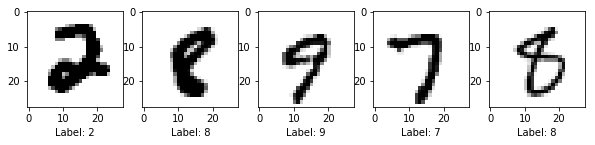

In [45]:
# Download MINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(554)
X, y = mnist.get_data(target=mnist.default_target_attribute);
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Label: {}".format(y[n]))
plt.show();

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000)
print("Training set: ",X_train.shape)
print("Test set: ",X_test.shape)

Training set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


We can now build a simple neural network for MNIST:
* One dense hidden ReLU layer with 512 nodes
    - Input from a 28x28 matrix
* Output softmax layer with 10 nodes

``` python
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

```

In [47]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

'Visualize' the model using `summary()` 
- Also shows the number of model parameters (weights) that need to be learned

In [48]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### Compilation
We still need to specify how we want the network to be trained:
* __Loss function__: The objective function used to measure how well the model is doing, and steer itself in the right direction
    - e.g. Cross Entropy (_negative log likelihood_ or _log loss_) for classification
* __Optimizer__: How to optimize the model weights in every iteration.
    - usually a [variant of stochastic gradient descent](http://ruder.io/optimizing-gradient-descent/index.html#momentum)
    - RMSprop is a good all-round technique
* __Metrics__ to monitor performance during training and testing.
    - e.g. accuracy
    
``` python
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
```

In [49]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Cross-entropy loss (log loss)
* Measures how similar the actual and predicted probability distributions are
    - Compute cross-entropy $H(y,\hat{y})$ between true $y$ and predicted $\hat{y}$
    - Sum up over all training samples
$$ H(y,\hat{y}) = - \sum_{c=1}^C y_c \log(\hat{y}_c)$$

* For binary classification, this simplifies to 
$$ - \sum_{c=0,1} y_c \log(\hat{y}_c) = −(y \log(\hat{y})+ (1−y) \log(1−\hat{y}))$$

Cross-entropy loss

<img src="../images/09_cross-entropy.png" alt="ml" style="width: 600px;"/>

#### Preprocessing 
* Neural networks are sensitive to scaling, so always scale the inputs
* The network expects the data in shape (n, 28 * 28), so we also need to reshape
* We also need to categorically encode the labels
    - e.g. '4' becomes [0,0,0,0,1,0,0,0,0,0]

``` python
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
```

In [50]:
X_train = X_train.reshape((60000, 28 * 28))
X_test = X_test.reshape((10000, 28 * 28))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Training
Training (fitting) is done by __stochastic gradient descent__ (SGD).
* Optimizes the model parameters (weights)

In [51]:
network.fit(X_train, y_train, epochs=5, batch_size=128);

Epoch 1/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.2540 - acc: 0.9260
Epoch 2/5
60000/60000 [==============================] - 6s 96us/step - loss: 0.1009 - acc: 0.9698
Epoch 3/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0659 - acc: 0.9797
Epoch 4/5
60000/60000 [==============================] - 5s 84us/step - loss: 0.0467 - acc: 0.9858
Epoch 5/5
60000/60000 [==============================] - 5s 84us/step - loss: 0.0359 - acc: 0.9892


#### Prediction
We can now call `predict` or `predict_proba` to generate predictions

``` python
np.set_printoptions(precision=7)
print("Prediction: ",network.predict(X_test)[0])
```

In [52]:
np.set_printoptions(precision=7)
print("Prediction: ",network.predict(X_test)[0])
print("Label: ",y_test[0])

Prediction:  [0.        0.0000311 0.0000017 0.0000005 0.9999515 0.0000004 0.0000007
 0.0000121 0.0000012 0.0000007]
Label:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


#### Evaluation
Evaluate the trained model on the entire test set

``` python
test_loss, test_acc = network.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
```

In [53]:
test_loss, test_acc = network.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 64us/step
Test accuracy: 0.9782


#### Overfitting
* Our test set accuracy is quite a bit lower than our training set accuracy
* We've already seen many choices (moving pieces) that can still be optimized:
    - Number of layers
    - Number of nodes per layer
    - Activation functions
    - Loss function (and hyperparameters)
    - SGD optimizer (and hyperparameters)
    - Batch size
    - Number of epochs
* We'll get back to this soon

### Text data: preprocessing
* We can't just input text into a neural net, we need to create tensors
* First, create a _dictionary_ of words (e.g. 10000 more frequent words)
    * Every word is replaced with an ID (0..10000)
    * Less frequent words replaced with '?'
* We also cannot input categories (!), we need one-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.

### IMDB movie reviews
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))


Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


``` python
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
```

In [3]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print("Encoded review: ", train_data[0][0:10])
print("One-hot-encoded review: ", x_train[0][0:10])

# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print("Label: ", y_train[0])

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
One-hot-encoded review:  [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
Label:  1.0


#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
    - Also vectorize the labels: from 0/1 to float
    
``` python
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
```

In [4]:
from keras import models
from keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

For more control, you can explictly create the optimizer, loss, and metrics:

``` python
from keras import optimizers
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
```

#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples

``` python
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))
```

In [5]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))

We can now retrieve visualize the loss on the validation data
* The training loss keeps decreasing, due to gradient descent
* The validation loss peaks after a few epochs, after which the model starts to overfit

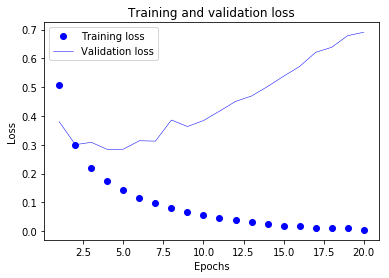

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

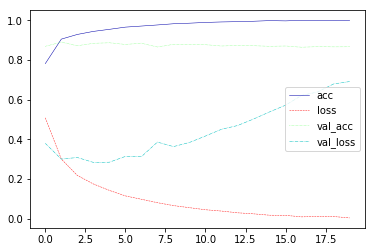

In [7]:
# Alternative plotting code
pd.DataFrame(history.history).plot();

We can also visualize the accuracy, with similar findings

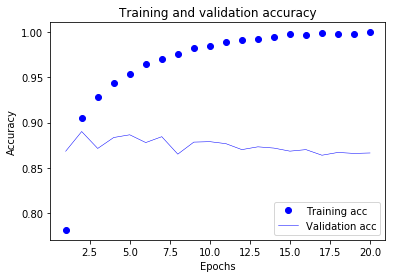

In [8]:
plt.clf()   # clear figure
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs

``` python
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=0)
result = model.evaluate(x_test, y_test)
```

In [9]:
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=0)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

25000/25000 [==============================] - 5s 183us/step
Loss: 0.4958, Accuracy:  0.8580


#### Predictions
Out of curiosity, let's look at a few predictions:

In [10]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

Review 0:  ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
Predicted positiveness:  [0.016]

Review 16:  ? from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem ? he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone could make the movie like this i don't believe so thanks

#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be done with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. Try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Wrapping Keras models as scikit-learn estimators
* Model selection can be tedious in pure Keras
* We can use all the power of scikit-learn by wrapping Keras models

``` python
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
clf = KerasClassifier(model)
param_grid = {'epochs': [1, 5, 10],  # epochs is a fit parameter
              'hidden_size': [32, 64, 256]} # this is a make_model parameter
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid.fit(x_train, y_train)
```

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

clf = KerasClassifier(make_model)
param_grid = {'epochs': [1, 5, 10],  # epochs is fit parameter, not in make_model!
              'hidden_size': [32, 64, 256],
              'verbose' : [0]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1c2ecd2c88>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'epochs': [1, 5, 10], 'hidden_size': [32, 64, 256], 'verbose': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Grid search results

In [12]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
                values=['mean_train_score', "mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_hidden_size                                   
1            32                            0.89              0.94
             64                            0.89              0.93
             256                           0.89              0.93
5            32                            0.88              0.97
             64                            0.88              0.97
             256                           0.88              0.97
10           32                            0.87              0.99
             64                            0.87              0.99
             256                           0.87              0.99

Go a bit deeper: 3 hidden layers
* Not really worth it, very similar results

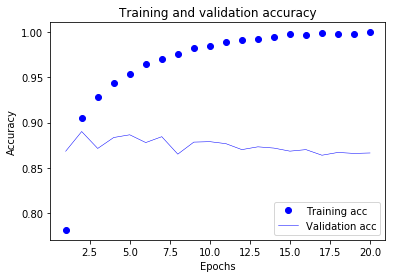

In [13]:
# Three hidden layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))
plt.clf()   # clear figure
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Multi-class classification (topic classification)
* Dataset: 11,000 news stories, 46 topics
    - Included in Keras, with a 50/50 train-test split
* Each row is one news story, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [14]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print("News wire: ",decoded_newswire)
print("Encoded: ", train_data[0][0:20])
print("Topic: ",train_labels[0])

News wire:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Encoded:  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7]
Topic:  3


#### Preparing the data
* We have to vectorize the data again (using one-hot-encoding)
* We have to vectorize the labels as well, also using one-hot-encoding
    - We can use Keras' `to_categorical` again
    - This yields a vector of 46 floats (0/1) for every sample
    
``` python
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
```

In [15]:
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

#### Building the network
* 16 hidden units may be too limited to learn 46 topics, hence we use 64 in each layer
* _Information bottleneck_: Every layer can `drop` some information, which can never be recovered by subsequent layers
* The output layer now needs 46 units, one for each topic
    - We use `softmax` activation for the output to get probabilities]
* The loss function is now `categorical_crossentropy`

``` python
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
```

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Model selection
* Take a validation set from the training set
* Fit again with 20 epochs

In [17]:
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, verbose=0,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Loss curve:

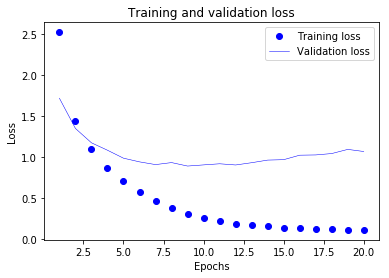

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Accuracy curve. Overfitting starts after about 8 epochs

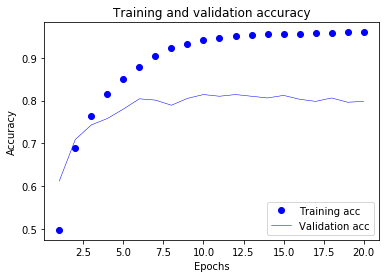

In [20]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Retrain with early stopping after 8 epochs and validate
``` python
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0,)
result = model.evaluate(x_test, one_hot_test_labels)
```

In [21]:
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0)
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

2246/2246 [==============================] - 0s 213us/step
Loss: 1.3879, Accuracy: 0.7631


#### Information bottleneck
* What happens if we create an information bottleneck on purpose
    - Use only 4 hidden units in the second layer
* Accuracy drops dramatically!
* We are trying to learn 64 separating hyperplanes from a 4-dimensional representation
    - It manages to save a lot of information, but also loses a lot
    
``` python
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
```

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128, verbose=0,
          validation_data=(x_val, y_val))
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

2246/2246 [==============================] - 0s 153us/step
Loss: 1.9652, Accuracy: 0.6990


#### Takeaways
* For a problem with $C$ classes, the final Dense layer needs $C$ units
* Use `softmax` activation and `categorical_crossentropy` loss
* Information bottleneck: when classifying many classes, the hidden layers should be large enough
* Many design choices have an effect on accuracy and overfitting. Try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 128)

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [23]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    
``` python
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std
```

In [24]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

``` python
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model
```

In [25]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* Luckily we can wrap a Keras model as a scikit-learn estimate
* We can also implement cross-validation ourselves (see notebook)
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    
``` python
clf = KerasClassifier(build_model)
score = cross_val_score(clf, train_data, train_targets, scoring='neg_mean_absolute_error', cv=4, fit_params={'epochs': 100, 'batch_size':1, 'verbose':0});
```

In [26]:
from sklearn.model_selection import cross_val_score
clf = KerasClassifier(build_model)
X = np.concatenate([train_data,test_data],axis=0)
y = np.concatenate([train_targets,test_targets],axis=0)
score = cross_val_score(clf, train_data, train_targets, scoring='neg_mean_absolute_error', cv=4,
                        fit_params={'epochs': 100, 'batch_size':1, 'verbose':0});
print("MAE: ", -np.mean(score))

MAE:  15.94628712871287


In [27]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [28]:
print("MAE: ", np.mean(all_scores))

MAE:  2.5091171695454286


Train for longer (500 epochs) and keep track of loss after every epoch  
(see code in notebook)

In [29]:
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


The model starts overfitting after epoch 80

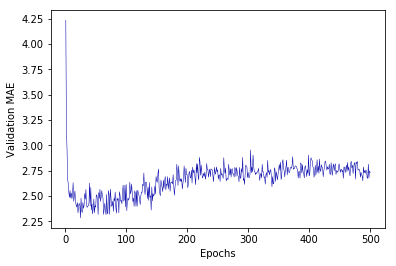

In [30]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Retrain with optimized number of epochs

``` python
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
```

In [31]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("MAE: ", test_mae_score)

102/102 [==============================] - 0s 577us/step
MAE:  2.498919066260843


#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer

``` python
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))
```

In [32]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [33]:
original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=0,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=0,
                                       validation_data=(x_test, y_test))

The smaller model starts overfitting later than the original one, and it overfits more _slowly_

In [34]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

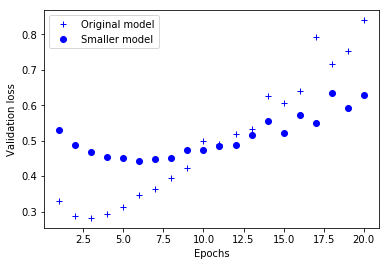

In [35]:
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

``` python
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))
```

In [36]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [38]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=0,
                             validation_data=(x_test, y_test))

L2 regularized model is much more resistant to overfitting, even though both have the same number of parameters

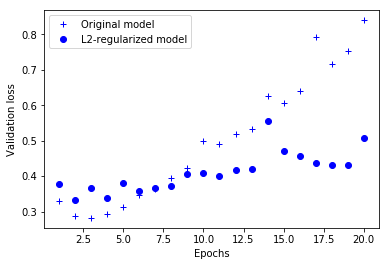

In [39]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

You can also try L1 loss or both at the same time
``` python
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Breakes up accidental non-significant learned patterns 
* Randomly set a number of outputs of the layer to 0
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* Nothing is dropped out at test time, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

``` python
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
```

In [40]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [41]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512, verbose=0,
                               validation_data=(x_test, y_test))

Dropout finds a better model, and overfits more slowly as well

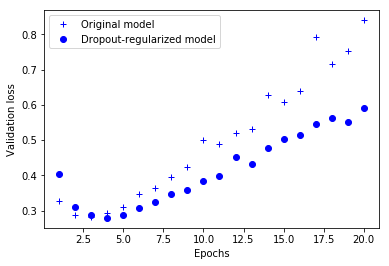

In [42]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout

## Convolutional neural nets
* When processing image data, we want to discover 'local' patterns (between nearby pixels)
    * edges, lines, structures
* Consider _windows_ (or _patches_) of pixels (e.g 5x5)

<img src="../images/10_patches.png" alt="ml" style="width: 300px;"/>

### Convolution
* Slide an $n$ x $n$ _filter_ (or _kernel_) over $n$ x $n$ _patches_ of the input feature map
* Replace pixel values with the convolution of the kernel with the underlying image patch

<img src="../images/10_conv_filtering.png" alt="ml" style="width: 500px;"/>

### Convolutional layers: Feature maps

* We slide $d$ filters across the input image in parallel, producing a (1x1xd) output per patch, reassembled into the final _feature map_ with $d$ channels.
* The filters are randomly initialized, we want to _learn_ the optimal values
<img src="../images/10_convolution.png" alt="ml" style="width: 400px;"/>

### Undersampling
* Sometimes, we want to _downsample_ a high-resolution image
    * Faster processing, less noisy (hence less overfitting)
* One approach is to _skip_ values during the convolution
    * Distance between 2 windows: _stride length_
* Example with stride length 2 (without padding):
    
<img src="../images/10_strides.png" alt="ml" style="width: 500px;"/>

### Max-pooling
* Another approach to shrink the input tensors is _max-pooling_:
    - Run a filter with a fixed stride length over the image
        - Usually 2x2 filters and stride lenght 2
    - The filter returns the _max_ (or _avg_) of all values
* Agressively reduces the number of weights (less overfitting)
* Information from every input node spreads more quickly to output nodes
    - In `pure` convnets, one input value spreads to 3x3 nodes of the first layer, 5x5 nodes of the second, etc.
    - You'd need much deeper networks, which are much harder to train

## Convolutional nets in practice
* Let's model MNIST again, this time using convnets
* `Conv2D` for 2D convolutional layers
    - Default: 32 filters, randomly initialized (from uniform distribution)
* `MaxPooling2D` for max-pooling
    - 2x2 pooling reduces the number of inputs by a factor 4
        
``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
```

In [56]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Observe how the input image is reduced to a 3x3x64 feature map

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Compare to the architecture without max-pooling:
* Output layer is a 22x22x64 feature map!

In [58]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


* To classify the images, we still need a Dense and Softmax layer.
* We need to flatten the 3x3x36 feature map to a vector of size 576

``` python
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
```

In [59]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                36928     
__________

In [61]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

* Train and test as usual (takes about 5 minutes):
* Compare to the 97,8% accuracy of the earlier dense architecture

``` python
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(test_images, test_labels)
```

In [62]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Accuracy: ", test_acc)

10000/10000 [==============================] - 4s 355us/step
Accuracy:  0.9921


## Using pretrained networks
* We can re-use pretrained networks instead of training from scratch
* Learned features can be a generic model of the visual world
* Use _convolutional base_ to contruct features, then train any classifier on new data
<img src="../images/10_pretraining.png" alt="ml" style="width: 600px;"/>

* Let's instantiate the VGG16 model (without the dense layers)
* Final feature map has shape (4, 4, 512)
``` python
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
```

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Using pre-trained networks: 3 ways
* Fast feature extraction without data augmentation
    - Call `predict` from the convolutional base
    - Use results to train a dense neural net
* Feature extraction with data augmentation
    - Extend the convolutional base model with a Dense layer
    - Run it end to end on the new data (expensive!)
* Fine-tuning
    - Do any of the above two to train a classifier
    - Unfreeze a few of the top convolutional layers
        - Updates only the more abstract representations
    - Jointly train all layers on the new data

### Fast feature extraction without data augmentation
* Extract filtered images and their labels
    - You can use a data generator
    
``` python
generator = datagen.flow_from_directory(dir, target_size=(150, 150),
        batch_size=batch_size, class_mode='binary')
for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
```

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

* Build Dense neural net (with Dropout)
* Train and evaluate with the transformed examples

``` python
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, verbose=0,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

In [ ]:
* Validation accuracy around 90%, much better!
* Still overfitting, despite the Dropout: not enough training data

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Feature extraction with data augmentation
* Use data augmentation to get more training data
* Simply add the Dense layers to the convolutional base
* _Freeze_ the convolutional base (before you compile)

``` python
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
```

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
##### Takes a long time. Uncomment if you really want to run it
``` python
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=0)
```

Data augmentation and training (takes a LONG time) 
``` python
train_datagen = ImageDataGenerator(
      rescale=1./255, rotation_range=40, width_shift_range=0.2,
      height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
      horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(dir,
      target_size=(150, 150), batch_size=20, class_mode='binary')
history = model.fit_generator(
      train_generator, steps_per_epoch=100, epochs=30,
      validation_data=validation_generator, validation_steps=50)
```

In [ ]:
model.save(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We now get about 96% accuracy, and very little overfitting

<img src="../images/10_tmp_results.png" alt="ml" style="float: left; width: 45%;"/>
<img src="../images/10_tmp_results_2.png" alt="ml" style="float: left; width: 45%;"/>

### Fine-tuning
* Add your custom network on top of an already trained base network.
* Freeze the base network.
* Train the part you added.
* Unfreeze some layers in the base network.
* Jointly train both these layers and the part you added.

``` python
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        layer.trainable = False
```

Visualized

<img src="../images/10_vgg16_fine_tuning.png" alt="ml" style="float: left; width: 45%;"/>
<img src="../images/10_vgg16_fine_tuning2.png" alt="ml" style="float: left; width: 45%;"/>

* Load trained network, finetune
    - Use a small learning rate, large number of epochs
    - You don't want to unlearn too much 
    
``` python
model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator, steps_per_epoch=100, epochs=100,
      validation_data=validation_generator,
      validation_steps=50)
```

## Take-aways
* Convnets are ideal for attacking visual-classification problems.
* They learn a hierarchy of modular patterns and concepts to represent the visual world.
* Representations are easy to inspect
* Data augmentation helps fight overfitting
* Batch normalization helps train deeper networks
* You can use a pretrained convnet to do feature extraction and fine-tuning